In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision.transforms import v2
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
cudnn.benchmark = True
plt.ion()

In [81]:
import torch
from tools.sam import SAM
import timm

In [82]:
test_path = 'test'

In [83]:
model = timm.create_model('tf_efficientnetv2_l', pretrained=True)

In [84]:
data_config = timm.data.resolve_model_data_config(model)
auto_transform = timm.data.create_transform(**data_config, is_training=False)
auto_transform

Compose(
    Resize(size=(384, 384), interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(384, 384))
    ToTensor()
    Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
)

In [85]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((480, 480)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((480, 480)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [86]:
data_dir = 'split_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

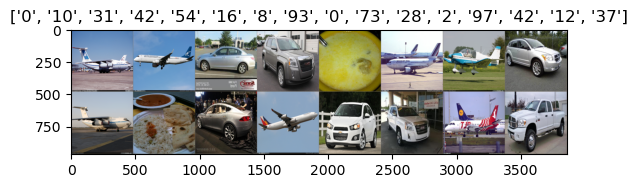

In [87]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [88]:
for name, param in model.named_parameters():
    param.requires_grad = False
    print(name)

conv_stem.weight
bn1.weight
bn1.bias
blocks.0.0.conv.weight
blocks.0.0.bn1.weight
blocks.0.0.bn1.bias
blocks.0.1.conv.weight
blocks.0.1.bn1.weight
blocks.0.1.bn1.bias
blocks.0.2.conv.weight
blocks.0.2.bn1.weight
blocks.0.2.bn1.bias
blocks.0.3.conv.weight
blocks.0.3.bn1.weight
blocks.0.3.bn1.bias
blocks.1.0.conv_exp.weight
blocks.1.0.bn1.weight
blocks.1.0.bn1.bias
blocks.1.0.conv_pwl.weight
blocks.1.0.bn2.weight
blocks.1.0.bn2.bias
blocks.1.1.conv_exp.weight
blocks.1.1.bn1.weight
blocks.1.1.bn1.bias
blocks.1.1.conv_pwl.weight
blocks.1.1.bn2.weight
blocks.1.1.bn2.bias
blocks.1.2.conv_exp.weight
blocks.1.2.bn1.weight
blocks.1.2.bn1.bias
blocks.1.2.conv_pwl.weight
blocks.1.2.bn2.weight
blocks.1.2.bn2.bias
blocks.1.3.conv_exp.weight
blocks.1.3.bn1.weight
blocks.1.3.bn1.bias
blocks.1.3.conv_pwl.weight
blocks.1.3.bn2.weight
blocks.1.3.bn2.bias
blocks.1.4.conv_exp.weight
blocks.1.4.bn1.weight
blocks.1.4.bn1.bias
blocks.1.4.conv_pwl.weight
blocks.1.4.bn2.weight
blocks.1.4.bn2.bias
blocks.1.5.co

In [89]:
from torchinfo import summary

for param in model.blocks[-1:].parameters():
    param.requires_grad = True

summary(model, input_size=(16, 3, 480, 480), col_names=["trainable"])

Layer (type:depth-idx)                        Trainable
EfficientNet                                  Partial
├─Conv2dSame: 1-1                             False
├─BatchNormAct2d: 1-2                         False
│    └─Identity: 2-1                          --
│    └─SiLU: 2-2                              --
├─Sequential: 1-3                             Partial
│    └─Sequential: 2-3                        False
│    │    └─ConvBnAct: 3-1                    False
│    │    └─ConvBnAct: 3-2                    False
│    │    └─ConvBnAct: 3-3                    False
│    │    └─ConvBnAct: 3-4                    False
│    └─Sequential: 2-4                        False
│    │    └─EdgeResidual: 3-5                 False
│    │    └─EdgeResidual: 3-6                 False
│    │    └─EdgeResidual: 3-7                 False
│    │    └─EdgeResidual: 3-8                 False
│    │    └─EdgeResidual: 3-9                 False
│    │    └─EdgeResidual: 3-10                False
│    │    

In [90]:

for name, param in model.named_parameters():
    if name == 'bn2.weight' or name == 'bn2.bias'or name == 'conv_head.weight':
        param.requires_grad = True
   
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.25),
    nn.Linear(num_ftrs, 100)
)

summary(model, input_size=(16, 3, 480, 480), col_names=["trainable"])

Layer (type:depth-idx)                        Trainable
EfficientNet                                  Partial
├─Conv2dSame: 1-1                             False
├─BatchNormAct2d: 1-2                         False
│    └─Identity: 2-1                          --
│    └─SiLU: 2-2                              --
├─Sequential: 1-3                             Partial
│    └─Sequential: 2-3                        False
│    │    └─ConvBnAct: 3-1                    False
│    │    └─ConvBnAct: 3-2                    False
│    │    └─ConvBnAct: 3-3                    False
│    │    └─ConvBnAct: 3-4                    False
│    └─Sequential: 2-4                        False
│    │    └─EdgeResidual: 3-5                 False
│    │    └─EdgeResidual: 3-6                 False
│    │    └─EdgeResidual: 3-7                 False
│    │    └─EdgeResidual: 3-8                 False
│    │    └─EdgeResidual: 3-9                 False
│    │    └─EdgeResidual: 3-10                False
│    │    

In [91]:
loss_fn = nn.CrossEntropyLoss()
base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, lr=0.004, momentum=0.9, rho=1.75)

In [92]:
from tools.engine import sam_train
from tools.test_tracking import create_writer
writer = create_writer('Best_EffNet_L')
save_path = 'models/Best_EffNet_L'

In [95]:
sam_train(model=model, train_loader=dataloaders['train'], test_loader=dataloaders['val'], loss_fn=loss_fn, optimizer=optimizer, num_epochs=100, writer=writer, save_path=save_path, offset=200)

  0%|          | 0/100 [00:00<?, ?it/s]

({'train_loss': [0.0006747760650250711,
   0.0006466392064066894,
   0.0008015704320678196,
   0.0007205841900213273,
   0.0008094342486765527,
   0.000678556559541903,
   0.0005886483298672829,
   0.0005152702547457011,
   0.0008629689680856246,
   0.0008286096593747061,
   0.0006027479191652674,
   0.0005895021385549626,
   0.0005855222418995254,
   0.0005082025060801243,
   0.0005989182959729078,
   0.0005735896489386505,
   0.0005210146009085293,
   0.0005576215916516957,
   0.0005459047988188104,
   0.0005095545136282454,
   0.0005891604623411695,
   0.000730969566047861,
   0.0007946805763640441,
   0.0006628627294412581,
   0.0005667517991878412,
   0.0007593290192380664,
   0.000738887305778917,
   0.0005708241906177136,
   0.0007769275704231404,
   0.0006249241676960082,
   0.0007169090923525801,
   0.0006061375679109915,
   0.0008502174976456444,
   0.0005046307300290209,
   0.0005403977653077164,
   0.000988090255887073,
   0.0010518407593008306,
   0.0006103016244833271,
  

In [96]:
# try model on test data, and save the results in a csv file. left column is the image name, right column is the predicted class
import pandas as pd
import os
from PIL import Image
from torchvision import transforms

def test_model(model, test_path):
    model.eval()
    test_images = os.listdir(test_path)
    results = []
    for image in test_images:
        img_path = os.path.join(test_path, image)
        img = Image.open(img_path).convert('RGB')
        img = data_transforms['val'](img)
        img = img.unsqueeze(0)
        img = img.to(device)
        output = model(img)
        _, preds = torch.max(output, 1)
        results.append([image, class_names[preds.item()]])
    return results

results = test_model(model_conv, test_path)
df = pd.DataFrame(results, columns=['ID', 'Label'])
df.to_csv('results.csv', index=False)

